In [1]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, classification_report
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np

import sys
sys.path += ['../src/']
from model_baseline import RawActivityModel
from model_nature import Nature_model
from sklearn.naive_bayes import MultinomialNB
from utils import load_data
import yaml
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, classification_report, average_precision_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler




# Define colors for plots
colors = plt.get_cmap("tab10")

# Function to get label mappings based on the dimension
def get_label_mappings(dimension, year=None):
    if "gender" in str(dimension):
        label2index = {'m': 0, 'f': 1}
        index2label = {0: 'm', 1: 'f'}
    elif "demo_rep" in str(dimension):
        label2index = {'demo': 0, 'rep': 1}
        index2label = {0: 'demo', 1: 'rep'}
    elif "year" in str(dimension):
        label2index = {'old': 0, 'young': 1}
        index2label = {0: "old", 1: 'young'}
    else:
        label2index = {0: 0, 1: 1}  # Default binary classification if dimension is not specified
        index2label = {0: 0, 1: 1}
    
    return label2index, index2label

# Function to normalize confusion matrix
def normalize_confusion_matrix(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

 
    
# 1. Define paths
with open("../scripts/parameters.yaml", 'r') as stream:
    parameters = yaml.safe_load(stream)
dataset_path = Path(parameters['dataset_path'])
input_path = Path(parameters['input_path'])
folder_results = Path(parameters['folder_results'])
score_file = input_path / Path('scores.big.csv')
subreddit_names = np.load(input_path / Path("list_subreddits.npy"), allow_pickle=True)
DIMENSIONS = ['year', 'gender', 'demo_rep']

---------

# ROC Curves (Fig 2/3)






---> DIMENSION: year
 -- declaration data:

   Scipy sparse data matrices already exist at ../data/dataset/year__body:  loading them
Loaded data X:(382429, 10000), y:(382429,)  ✅

 -- distance-supervision data:

   Scipy sparse data matrices already exist at ../data/dataset/year__nature_seeds:  loading them
Loaded data X:(2810, 10000), y:(2810,)  ✅

 -----
Evaluating model: WA for dimension: year

 -----
Evaluating model: NB for dimension: year





---> DIMENSION: gender
 -- declaration data:

   Scipy sparse data matrices already exist at ../data/dataset/gender__body:  loading them
Loaded data X:(383467, 10000), y:(383467,)  ✅

 -- distance-supervision data:

   Scipy sparse data matrices already exist at ../data/dataset/gender__nature_seeds:  loading them
Loaded data X:(2250, 10000), y:(2250,)  ✅

 -----
Evaluating model: WA for dimension: gender

 -----
Evaluating model: NB for dimension: gender





---> DIMENSION: demo_rep
 -- declaration data:

   Scipy sparse data matrices

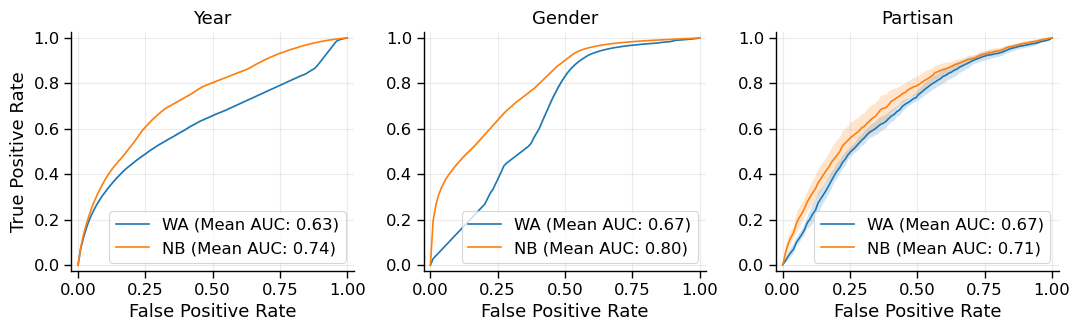

In [3]:
use_declaration_in_train = True ##### <------ (True -> true supervision, False -> distant supervision)



# Number of splits
K = 10
ALPHA_SIGMA = 1 if use_declaration_in_train else 1

fig, axs = plt.subplots(1, 3, figsize=(11, 3.5))

for i, dimension in enumerate(DIMENSIONS):
    print("\n\n\n")
    print("=="*10)
    print(f"\n---> DIMENSION: {dimension}")
    
    # Load data
    print(" -- declaration data:")
    X_declarations, y_declarations = load_data(attribute_path=dataset_path / Path(f"{dimension}__body"),
                                               attribute_to_label=None,
                                               input_path=input_path,
                                               use_bool_features=False,
                                               save=True)
    print("\n -- distance-supervision data:")
    X_nature_seeds, y_nature_seeds = load_data(attribute_path = dataset_path / Path(f"{dimension}__nature_seeds"),
                                                attribute_to_label = dataset_path / Path(f"{dimension}__nature_seeds"),
                                                input_path = input_path,
                                                use_bool_features = False,
                                                save = True)
    
    
    attribute = dimension
    if attribute == "demo_rep":
        attribute = "partisan"
        
    # Initialize models
    nature_model = Nature_model(score_file=score_file, subreddit_names=subreddit_names, attribute=attribute)
    model_NB = MultinomialNB()
    
    
    # Loop through each model and plot
    for jj, (name, model) in enumerate([("WA", nature_model), ("NB", model_NB)]):
        print("\n", "-"*5)
        print(f"Evaluating model: {name} for dimension: {dimension}")
        
        # Initialize variables to store ROC data
        tpr_list = []
        fpr_list = []
        auc_scores = []

        # Stratified K-Fold Cross-Validation
        skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
        
        _X, _y = (X_declarations, y_declarations) if use_declaration_in_train else (X_nature_seeds, y_nature_seeds)
        __X, __y = (X_declarations, y_declarations)

        for train_index, test_index in skf.split(_X, _y):
            X_train, X_test = _X[train_index], __X[test_index]
            y_train, y_test = _y[train_index], __y[test_index]
            rus = RandomOverSampler(sampling_strategy=1)
            X_train, y_train = rus.fit_resample(X_train, y_train)
            
            
            # Fit model on training data
            model.fit(X_train, y_train)
            
            # Get prediction probabilities
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # binary classification
            
            # ROC curve and AUC score
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            # Store results for averaging
            tpr_list.append(np.interp(np.linspace(0, 1, 100), fpr, tpr))
            fpr_list.append(np.linspace(0, 1, 100))
            auc_scores.append(roc_auc)
        
        # Compute mean and std deviation of TPR values
        mean_tpr = np.mean(tpr_list, axis=0)
        std_tpr = ALPHA_SIGMA * np.std(tpr_list, axis=0)
        mean_fpr = fpr_list[0]  # fpr_list contains identical FPR values for all splits
        
        # Plot mean ROC curve with std deviation shading
        axs[i].plot(mean_fpr, mean_tpr, label=f'{name.replace("model", "").replace("_", "")} (Mean AUC: {np.mean(auc_scores):.2f})', color=colors(jj))
        axs[i].fill_between(mean_fpr, 
                         mean_tpr - std_tpr, 
                         mean_tpr + std_tpr, 
                         alpha=0.2)
        # Finalize the plot with a legend
        axs[i].set_title(f"{dimension.replace('demo_rep', 'partisan').capitalize()}")
        axs[i].set_xlabel("False Positive Rate")
        if i>0:
            axs[i].set_ylabel("")
            #axs[i].set_yticklabels([])
        else:
            axs[i].set_ylabel("True Positive Rate")
        ε = .025
        axs[i].set_xlim(0-ε, 1.+ε)
        axs[i].set_ylim(0-ε, 1.+ε)
        axs[i].grid(alpha=.25)
        axs[i].legend(loc="lower right")
        sns.set_context("paper", font_scale=1.35) 
        sns.despine()

__ = 'distant-supervision' if not use_declaration_in_train else 'supervision'
filename = f'ROC-all-dimensions-{__}.pdf'
plt.tight_layout()
plt.savefig(f'../data/figures/{filename}', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


----------

# Model Transparency: Calibration curves (Fig 5)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path

# Define constants and colors
DIMENSIONS = ['year', 'gender', 'demo_rep']
colors = plt.get_cmap("tab10")
markers = ["o", "s", "^", "v", "D", "x", "P", "*", "h", "<", ">"]


Processing dimension: year

   Scipy sparse data matrices already exist at ../data/dataset/year__body:  loading them
Loaded data X:(382429, 10000), y:(382429,)  ✅

   Scipy sparse data matrices already exist at ../data/dataset/year__nature_seeds:  loading them
Loaded data X:(2810, 10000), y:(2810,)  ✅


/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[
/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[
/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **lin


Processing dimension: gender

   Scipy sparse data matrices already exist at ../data/dataset/gender__body:  loading them
Loaded data X:(383467, 10000), y:(383467,)  ✅

   Scipy sparse data matrices already exist at ../data/dataset/gender__nature_seeds:  loading them
Loaded data X:(2250, 10000), y:(2250,)  ✅


/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[
/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[
/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **lin


Processing dimension: demo_rep

   Scipy sparse data matrices already exist at ../data/dataset/demo_rep__body:  loading them
Loaded data X:(5864, 10000), y:(5864,)  ✅

   Scipy sparse data matrices already exist at ../data/dataset/demo_rep__nature_seeds:  loading them
Loaded data X:(112, 10000), y:(112,)  ✅


/home/fcinus/miniconda3/envs/sdienv2/lib/python3.8/site-packages/sklearn/calibration.py:1198: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = self.ax_.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[


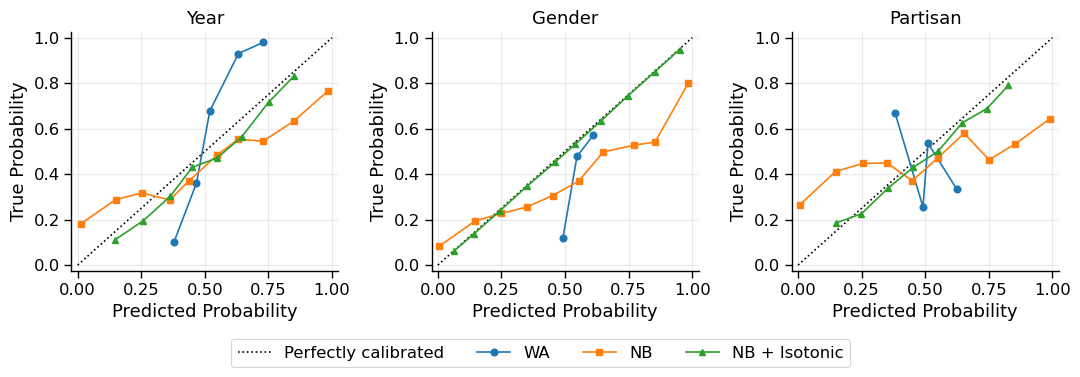

In [5]:
K = 5  # Number of folds
plot_hist = False

fig, ax_calibration_curve = plt.subplots(1, 3, figsize=(11, 3.5))

# Process each dimension
for i, dimension in enumerate(DIMENSIONS):
    print(f"\nProcessing dimension: {dimension}")

    # Load data
    X_declarations, y_declarations = load_data(
        attribute_path=dataset_path / Path(f"{dimension}__body"),
        attribute_to_label=None,
        input_path=input_path,
        use_bool_features=False,
        save=True,
    )
    X_nature_seeds, y_nature_seeds = load_data(
        attribute_path=dataset_path / Path(f"{dimension}__nature_seeds"),
        attribute_to_label=dataset_path / Path(f"{dimension}__nature_seeds"),
        input_path=input_path,
        use_bool_features=False,
        save=True,
    )

    # Initialize models
    attribute = "partisan" if dimension == "demo_rep" else dimension
    nature_model = Nature_model(score_file=score_file, subreddit_names=subreddit_names, attribute=attribute)
    model_NB = MultinomialNB()

    # Add calibrated models
    gnb_isotonic = CalibratedClassifierCV(model_NB, cv=4, method="isotonic")

    clf_list = [
        (nature_model, "WA"),
        (model_NB, "NB"),
        (gnb_isotonic, "NB + Isotonic"),
    ]
    calibration_displays = {}

    # Cross-validation and calibration display
    for jj, (clf, name) in enumerate(clf_list):
        skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
        _X, _y = (X_declarations, y_declarations)

        # Placeholder for histograms
        y_prob_hist = []
        y_test_curve = []

        for train_index, test_index in skf.split(_X, _y):
            X_train, X_test = _X[train_index], _X[test_index]
            y_train, y_test = _y[train_index], _y[test_index]

            # Handle class imbalance
            rus = RandomOverSampler(sampling_strategy=1)
            X_train, y_train = rus.fit_resample(X_train, y_train)

            # Fit the model
            clf.fit(X_train, y_train)

            # Predict probabilities
            y_pred_proba = clf.predict_proba(X_test)[:, 1]
            y_prob_hist.extend(y_pred_proba)  # Collect probabilities for histogram
            y_test_curve.extend(y_test)  # Collect true labels for calibration curve

        # Create calibration display
        display = CalibrationDisplay.from_predictions(
            y_test_curve,  # True labels from all folds
            y_prob_hist,   # Predicted probabilities from all folds
            n_bins=10,     # Number of bins for the calibration curve
            name=name,     # Model name
            ax=ax_calibration_curve[i],  # Axes for plotting
            color=colors(jj),  # Color for this model
            marker=markers[jj],
        )
        calibration_displays[name] = display

        # Plot histogram of predicted probabilities
        if plot_hist:
            row, col = divmod(jj, 2)  # Determine grid position
            ax_hist = fig.add_subplot(gs[2 + row, col])

            ax_hist.hist(
                y_prob_hist,
                range=(0, 1),
                bins=10,
                label=name,
                color=colors(jj),
                marker=markers[jj],
            )
            ax_hist.set(title=f"{name} ({dimension})", xlabel="Mean predicted probability", ylabel="Count")

    # Finalize calibration curve
    ax_calibration_curve[i].grid()
    ax_calibration_curve[i].set_title(f"{attribute.capitalize()}")
    ε = .025
    ax_calibration_curve[i].set_xlim(0-ε, 1.+ε)
    ax_calibration_curve[i].set_ylim(0-ε, 1.+ε)
    ax_calibration_curve[i].set_ylabel("True Probability")
    ax_calibration_curve[i].set_xlabel("Predicted Probability")
    ax_calibration_curve[i].grid(alpha=.25)
    # Force turn off the legend
    if ax_calibration_curve[i].get_legend() is not None:
        ax_calibration_curve[i].get_legend().remove()
    sns.set_context("paper", font_scale=1.35) 
    sns.despine()

handles, labels = ax_calibration_curve[0].get_legend_handles_labels()  # Collect from the first subplot
fig.legend(handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, -0.1))

__ = 'supervision'
filename = f'calibrations-{__}.pdf'
plt.tight_layout()
plt.savefig(f'../data/figures/{filename}', format='pdf', dpi=300, bbox_inches='tight')

-------

# Model transparency: Robustness Curves


Processing dimension: year

   Scipy sparse data matrices already exist at ../data/dataset/year__body:  loading them
Loaded data X:(382429, 10000), y:(382429,)  ✅

   Scipy sparse data matrices already exist at ../data/dataset/year__nature_seeds:  loading them
Loaded data X:(2810, 10000), y:(2810,)  ✅


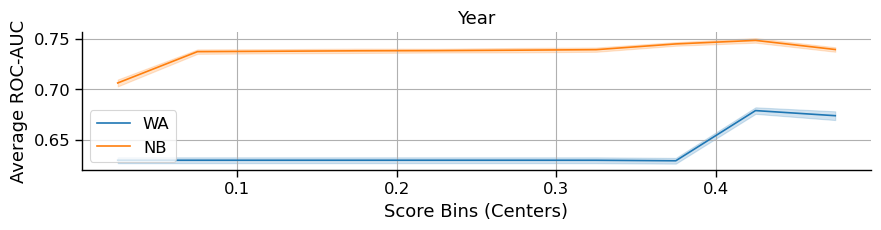


Processing dimension: gender

   Scipy sparse data matrices already exist at ../data/dataset/gender__body:  loading them
Loaded data X:(383467, 10000), y:(383467,)  ✅

   Scipy sparse data matrices already exist at ../data/dataset/gender__nature_seeds:  loading them
Loaded data X:(2250, 10000), y:(2250,)  ✅


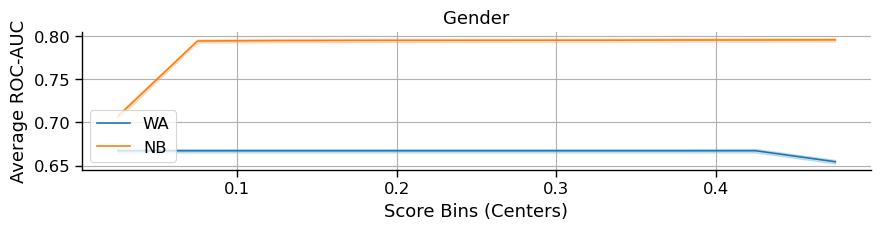


Processing dimension: demo_rep

   Scipy sparse data matrices already exist at ../data/dataset/demo_rep__body:  loading them
Loaded data X:(5864, 10000), y:(5864,)  ✅

   Scipy sparse data matrices already exist at ../data/dataset/demo_rep__nature_seeds:  loading them
Loaded data X:(112, 10000), y:(112,)  ✅


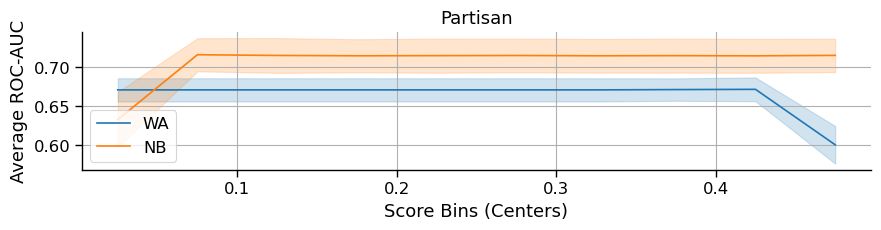

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path

# Define constants and colors
DIMENSIONS = ['year', 'gender', 'demo_rep']
colors = plt.get_cmap("tab10")
K = 10  # Number of folds for cross-validation
use_declaration_in_train = True


# Process each dimension
for i, dimension in enumerate(DIMENSIONS):
    # Initialize figure
    fig = plt.figure(figsize=(9, 8))
    gs = GridSpec(4, 2)
    ax_threshold_curve = fig.add_subplot(gs[2, :])  # Subplot for threshold analysis

    print(f"\nProcessing dimension: {dimension}")

    # Load data
    X_declarations, y_declarations = load_data(
        attribute_path=dataset_path / Path(f"{dimension}__body"),
        attribute_to_label=None,
        input_path=input_path,
        use_bool_features=False,
        save=True,
    )
    X_nature_seeds, y_nature_seeds = load_data(
        attribute_path=dataset_path / Path(f"{dimension}__nature_seeds"),
        attribute_to_label=dataset_path / Path(f"{dimension}__nature_seeds"),
        input_path=input_path,
        use_bool_features=False,
        save=True,
    )

    # Initialize models
    attribute = "partisan" if dimension == "demo_rep" else dimension
    nature_model = Nature_model(score_file=score_file, subreddit_names=subreddit_names, attribute=attribute)
    model_NB = MultinomialNB()

    clf_list = [
        (nature_model, "WA"),
        (model_NB, "NB"),
    ]

    # Define bins
    num_bins = 10  # Number of bins
    bin_edges = np.linspace(0.0, 0.5, num_bins + 1)  # Bin edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Bin centers for plotting

    # Process each classifier
    for jj, (clf, name) in enumerate(clf_list):
        skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
        _X, _y = (X_declarations, y_declarations) if use_declaration_in_train else (X_nature_seeds, y_nature_seeds)

        # Placeholder for per-bin ROC-AUC scores across folds
        fold_bin_roc_auc = [[] for _ in range(len(bin_edges) - 1)]

        for train_index, test_index in skf.split(_X, _y):
            X_train, X_test = _X[train_index], _X[test_index]
            y_train, y_test = _y[train_index], _y[test_index]

            # Handle class imbalance
            rus = RandomOverSampler(sampling_strategy=1)
            X_train, y_train = rus.fit_resample(X_train, y_train)

            # Fit the model
            clf.fit(X_train, y_train)

            # Predict probabilities
            y_pred_proba = clf.predict_proba(X_test)[:, 1]

            # Compute ROC-AUC for each bin
            for bin_idx, (bin_start, bin_end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
                # Mask for predictions within the bin range
                mask = (y_pred_proba <= bin_start) | (y_pred_proba >= bin_end)
                #print(bin_start, f"{bin_end:.1f}", "Data Points", np.sum(mask), "/", len(mask))

                
                if np.sum(mask) > 1 and len(np.unique(y_test[mask])) > 1:
                    roc_auc = roc_auc_score(y_test[mask], y_pred_proba[mask])
                    fold_bin_roc_auc[bin_idx].append(roc_auc)
                else:
                    fold_bin_roc_auc[bin_idx].append(np.nan)  # Handle insufficient samples

        # Average ROC-AUC across folds for each bin
        mean_roc_auc = [np.nanmean(scores) for scores in fold_bin_roc_auc]
        std_roc_auc = [np.nanstd(scores) for scores in fold_bin_roc_auc]

        # Plot ROC-AUC vs Bin Centers
        ax_threshold_curve.plot(
            bin_centers, mean_roc_auc, label=name, color=colors(jj)
        )
        ax_threshold_curve.fill_between(
            bin_centers,
            np.array(mean_roc_auc) - np.array(std_roc_auc),
            np.array(mean_roc_auc) + np.array(std_roc_auc),
            color=colors(jj),
            alpha=0.2,
        )

    # Finalize plot
    ax_threshold_curve.set_xlabel("Score Bins (Centers)")
    ax_threshold_curve.set_ylabel("Average ROC-AUC")
    ax_threshold_curve.set_title(f"{attribute.capitalize()}")
    ax_threshold_curve.legend(loc='lower left')
    ax_threshold_curve.grid()
    sns.set_context("paper", font_scale=1.35) 
    sns.despine()

    __ = 'distant-supervision' if not use_declaration_in_train else 'supervision'
    filename = f'thresholds-curves-{attribute}-{__}.pdf'
    plt.tight_layout()
    plt.savefig(f'../../draft/figures/{filename}', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


--------